# Part 1 - Clean and preprocess the data 

## Import required libraries

In [28]:
#reading/manipulating the data
import pandas as pd
import numpy as np
import pickle

#plotting the data
import matplotlib.pyplot as plt
%matplotlib inline

#machine learning libraries  - KNN etc. 
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
from sklearn import tree
from sklearn.metrics import roc_curve, auc

## Get the column names

In [29]:
col_headers = []

with open('data/dataDescription.txt', 'r') as dd:
    for line in dd:
        if line[0].isdigit():
            items = line.split(' ')
            col_headers.append(items[2].strip().replace(':', ''))
col_headers = []

with open('data/dataDescription.txt', 'r') as dd:
    for line in dd:
        if line[0].isdigit():
            items = line.split(' ')
            col_headers.append(items[2].strip().replace(':', ''))

## read in the training set

In [30]:
df = pd.read_csv('data/trainingSet.txt', header=None)
#assigns column headers to the data
df.columns = col_headers

## Convert categorical features to numerical format

In [31]:
#categorical columns
cat_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'y']

#pass the data to the get dummies function along with the columns needed to convert 
df_with_dummies = pd.get_dummies(df, columns = cat_features )

#convert it to CSV format
df.to_csv('./data/trainingSetLabelled.csv', index=False)

## Read in the labelled training data

In [32]:
campaign_data = pd.read_csv('./data/trainingSetLabelled.csv') 

In [33]:
#get the target features and save them
target_label = campaign_data['y']
target_label.to_csv('./data/target_features.csv', index=False)

## Extract the numeric descriptive features

In [34]:
numeric_features = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
num_df = campaign_data[numeric_features]

## Extract the Categorical Features

In [35]:
cat_df = campaign_data.drop(numeric_features + ['id','y'], axis=1)

In [36]:
# Clean up empty values
cat_df.replace('?', 'NA')
cat_df.fillna('NA', inplace=True)

In [37]:
## Convert to numerical using one hot encoding
#one hot encoding using get_dummies()
vec_cat_df = pd.get_dummies(cat_df)

## Merge categorical and numerical features

In [38]:
train_df = np.hstack((num_df.as_matrix(), vec_cat_df))

In [39]:
#save the data
np.save('./data/cleaned_data_np', train_df)

# Part 2 - Train and evaluate the model (stratified k-fold)

In [40]:
x_data = np.load('./data/cleaned_data_np.npy')
y_data = pd.read_csv('./data/target_features.csv', header=None)

#init skf
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
skf.get_n_splits(x_data, y_data)

10

In [41]:
#convert target to binary format
le = preprocessing.LabelEncoder()
le.fit(y_data)
y_data = le.transform(y_data)

base_fpr = np.linspace(0, 1, 101)

/home/dbutler/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:112: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/dbutler/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## A) Decision Tree

Accuracy= 0.8277846280312372
Count{0: 2123, 1: 310}
The Area under the curve0.6018497822335442
Accuracy= 0.8224414303329223
Count{0: 2092, 1: 341}
The Area under the curve0.6126345632344481
Accuracy= 0.8401150842581175
Count{0: 2125, 1: 308}
The Area under the curve0.6303056947982578
Accuracy= 0.8404605263157895
Count{0: 2144, 1: 288}
The Area under the curve0.6155335642421245
Accuracy= 0.8400493421052632
Count{0: 2155, 1: 277}
The Area under the curve0.6060580570674583
Accuracy= 0.8391608391608392
Count{0: 2122, 1: 309}
The Area under the curve0.6286776960420317
Accuracy= 0.8354586589880707
Count{0: 2107, 1: 324}
The Area under the curve0.6312048487008637
Accuracy= 0.8153023447141095
Count{0: 2110, 1: 321}
The Area under the curve0.5797542317224901
Accuracy= 0.8194158782394076
Count{0: 2114, 1: 317}
The Area under the curve0.5867020451537743
Accuracy= 0.8301110654051831
Count{0: 2126, 1: 305}
The Area under the curve0.6035340534439572


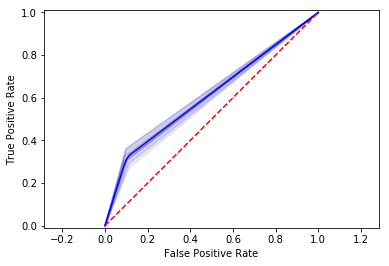

In [42]:
#hold data for ROC
tprs = []

for train_index, test_index in skf.split(x_data, y_data):
    
    #Decsion Tree - Better 
    #create dec tree instance
    decTreeModel = tree.DecisionTreeClassifier()
    #fit the model
    decTreeModel.fit(x_data[train_index], y_data[train_index])
    #generate testset predictions
    predictions = decTreeModel.predict(x_data[test_index])
    
    #output the accuracy
    print('Accuracy= ' + str(accuracy_score(y_data[test_index], predictions, normalize=True)))
    
    #get target counts
    unique, counts = np.unique(predictions, return_counts = True)
    res = dict(zip(unique, counts))
    print("Count" + str(res))
    
    #calculate ROC
    fpr, tpr, _ = roc_curve(y_data[test_index], predictions[:])
    print("The Area under the curve" + str(auc(fpr, tpr)))
    plt.plot(fpr, tpr, 'b', alpha=0.15)
    tpr = np.interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tprs.append(tpr)

tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)

tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std


plt.plot(base_fpr, mean_tprs, 'b')
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.axes().set_aspect('equal', 'datalim')
plt.show()

## B) KNN

Accuracy= 0.8795725441841348
Count{0: 2399, 1: 34}
The Area under the curve0.5160851343577945
Accuracy= 0.8836826962597616
Count{0: 2405, 1: 28}
The Area under the curve0.5214791683786669
Accuracy= 0.885737772297575
Count{0: 2416, 1: 17}
The Area under the curve0.5180392801380557
Accuracy= 0.8844572368421053
Count{0: 2399, 1: 33}
The Area under the curve0.5264209137390731
Accuracy= 0.884046052631579
Count{0: 2408, 1: 24}
The Area under the curve0.5184858980702622
Accuracy= 0.8819415878239407
Count{0: 2412, 1: 19}
The Area under the curve0.5096193512403923
Accuracy= 0.8852324146441793
Count{0: 2414, 1: 17}
The Area under the curve0.5161018319587867
Accuracy= 0.8807075277663513
Count{0: 2401, 1: 30}
The Area under the curve0.5150828853268384
Accuracy= 0.8823529411764706
Count{0: 2407, 1: 24}
The Area under the curve0.5144731674636727
Accuracy= 0.8798848210612916
Count{0: 2401, 1: 30}
The Area under the curve0.5130771693250035


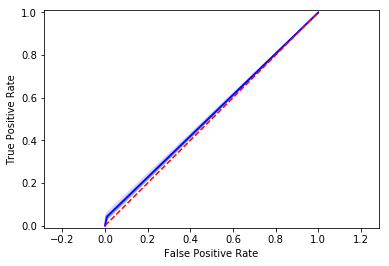

In [43]:
from sklearn.naive_bayes import GaussianNB

#init skf
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
skf.get_n_splits(x_data, y_data)

#hold data for ROC
tprs = []

for train_index, test_index in skf.split(x_data, y_data):
    
    #KNN
    knn = KNeighborsClassifier(n_neighbors=10)
    knn.fit(x_data[train_index], y_data[train_index])
    predictions = knn.predict(x_data[test_index])
    #print(accuracy_score(y_data[test_index], results))
    #output the accuracy
    print('Accuracy= ' + str(accuracy_score(y_data[test_index], predictions, normalize=True)))
    
    #get target counts
    unique, counts = np.unique(predictions, return_counts = True)
    res = dict(zip(unique, counts))
    print("Count" + str(res))
    
    #calculate ROC
    fpr, tpr, _ = roc_curve(y_data[test_index], predictions[:])
    print("The Area under the curve" + str(auc(fpr, tpr)))
    plt.plot(fpr, tpr, 'b', alpha=0.15)
    tpr = np.interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tprs.append(tpr)

tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)

tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std


plt.plot(base_fpr, mean_tprs, 'b')
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.axes().set_aspect('equal', 'datalim')
plt.show()

# Fit data to Decision Tree
* The AUC for the decision tree was much higher than that of the knn model
* This indicated that the knn model was overfitting the data due to the large imbalance in the set

## Fit the model the the whole training data set

In [44]:
#create dec tree instance
decTreeModel = tree.DecisionTreeClassifier()
#fit the model
decTreeModel.fit(x_data, y_data)
#save the model
pickle.dump(decTreeModel, open('DTModel.sav', 'wb'))

# Part 3 - Classify the query data

In [45]:
#get the queries
df = pd.read_csv('data/queries.txt', header=None)
#assigns column headers to the data
df.columns = col_headers
df.to_csv('./data/queriesLabelled.csv', index=False)

In [46]:
queries_df = pd.read_csv('./data/queriesLabelled.csv') 
numeric_features = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
num_df = queries_df[numeric_features]

In [47]:
#keep the ID seperate
target_id = queries_df['id']

In [48]:
cat_df = queries_df.drop(numeric_features + ['id','y'], axis=1)

In [49]:
cat_df.replace('?', 'NA')
cat_df.fillna('NA', inplace=True)

## Perform one hot encoding on data

In [50]:
#one hot encoding using get_dummies()
vec_cat_df = pd.get_dummies(cat_df)

In [51]:
#merge the cat & num columns
train_df = np.hstack((num_df.as_matrix(), vec_cat_df))

In [52]:
#load model and predict outcome
dt = pickle.load(open('DTModel.sav', 'rb'))
#generate testset predictions
predictions = dt.predict(train_df)

In [53]:
target_id.to_csv('./data/results.txt', index=False)

In [54]:
#write to file
i = 0
with open('./data/predictions.txt', 'a') as pred_file:
    with open('./data/results.txt', 'r+') as res_file:
        for line in res_file:
            if predictions[i] == 0:
                pred_file.write(line.strip() + ',"TypeA"\n')
            else:
                pred_file.write(line.strip() + ',"TypeB"\n')
            i += 1